# River pollution problem (all objectives minimized)

In [21]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from desdeo_problem.problem import DiscreteDataProblem
from desdeo_tools.scalarization import SimpleASF, DiscreteScalarizer, StomASF, PointMethodASF
from desdeo_tools.solver import DiscreteMinimizer
from shapley_values.explanations import *
from shapley_values.utilities import *
from IPython.core.display import display, HTML


# Load and setup problem
df = pd.read_csv("../data/river_pollution_10178.csv")
pareto_front = df.to_numpy()

ideal = np.min(pareto_front[:, 0:5], axis=0)
nadir = np.max(pareto_front[:, 0:5], axis=0)

objective_names = ["f_1", "f_2", "f_3", "f_4", "f_5"]
n_objectives = len(objective_names)

problem = DiscreteDataProblem(df, ["x_1", "x_2"], objective_names, nadir, ideal)

# asf = SimpleASF(np.array([1,1,1,1,1]))
asf = StomASF(ideal)
# asf = PointMethodASF(nadir, ideal)

missing_data = shap.sample(pareto_front[:, 0:n_objectives], nsamples=200)

# need to know reference point before generating missing data
bb = generate_black_box(problem, asf)
explainer = shap.KernelExplainer(bb, missing_data)

normalizer = Normalizer(ideal, nadir)

def plot(result, objective_names=objective_names, ymin=0, ymax=1):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim(ymin, ymax)
    ax.bar(objective_names, np.squeeze(result)) 
    plt.grid()
    plt.show()

print(f"Ideal: {ideal}")
print(f"Nadir: {nadir}")
print(np.abs(nadir - ideal))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Ideal: [-6.34000000e+00 -3.44487179e+00 -7.50000000e+00  0.00000000e+00
  1.71409445e-03]
Nadir: [-4.751      -2.85595261 -0.32111111  9.70666667  0.35      ]
[1.589      0.58891919 7.17888889 9.70666667 0.34828591]


## 1st iteration

Reference point: [-6.34 -3.44 -7.5   0.    0.  ]
Result: [[-5.74608375 -2.91090165 -6.9068179   0.20337037  0.13540173]]


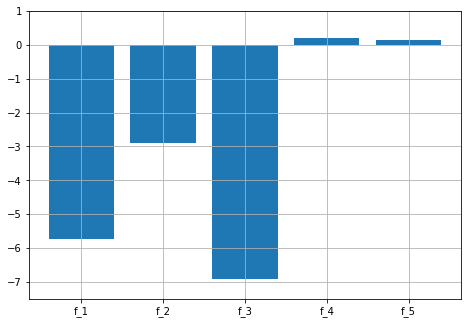

In [22]:
ref_point = np.array([-6.34, -3.44, -7.5, 0, 0])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))

#print(f"SHAP values:\n{shap_values}")

## Selecting the objective to be improved #1

In [23]:
to_improve = 0
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))

## 2nd iteration

Reference point: [-6.  -3.2 -6.   0.1  0.1]
Result: [[-6.00345962 -2.91928927 -6.26229508  0.21316082  0.20174433]]


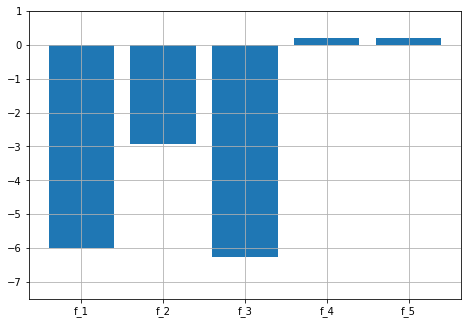

In [24]:
ref_point = np.array([-6, -3.2, -6.0, 0.1, 0.1])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))

## Selecting the objective to be improved #2

# to_improve = 3
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))

## 3rd teration

Reference point: [-6.  -3.2 -6.   1.   0.1]
Result: [[-5.90002751 -3.05750649 -6.59663711  1.20663092  0.15617952]]


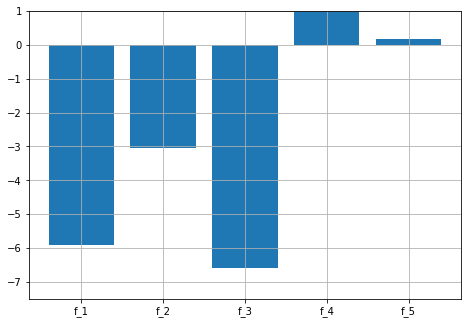

In [25]:
ref_point = np.array([-6, -3.2, -6.0, 1, 0.1])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))

## Selecting the objective to be improved #3

In [26]:
to_improve = 1
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))

##  4th iteration

Reference point: [-6.   -3.2  -5.5   0.8   0.12]
Result: [[-5.95206821 -3.06336352 -6.44639728  1.24607038  0.17910494]]


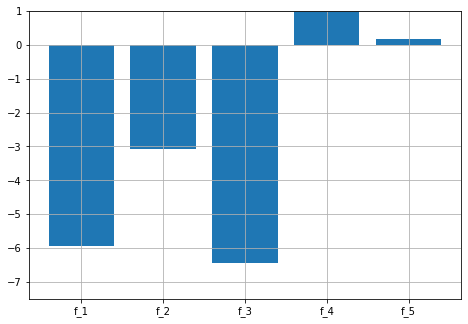

In [27]:
ref_point = np.array([-6, -3.2, -5.5, 0.8, 0.12])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))

## Selecting the objective to be improved #5

In [28]:
to_improve = 3
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))

##  5th iteration

Reference point: [-6.   -3.2  -5.5   0.8   0.12]
Result: [[-5.95206821 -3.06336352 -6.44639728  1.24607038  0.17910494]]


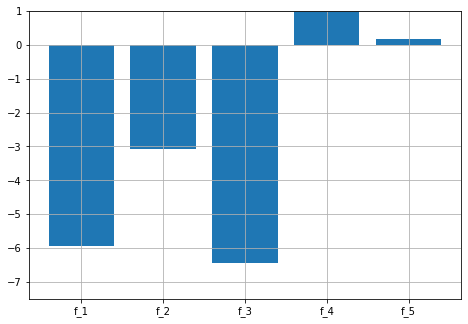

In [29]:
ref_point = np.array([-6, -3.2, -5.5, 0.8, 0.12])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))

## Selecting the objective to be improved #5

In [30]:
to_improve = 3
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))

##  6th iteration

Reference point: [-6.   -3.2  -5.5   0.8   0.12]
Result: [[-5.95206821 -3.06336352 -6.44639728  1.24607038  0.17910494]]


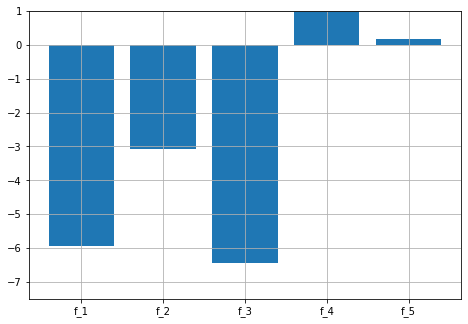

In [31]:
ref_point = np.array([-6, -3.2, -5.5, 0.8, 0.12])

result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Result: {result}")
plot(result, ymin=np.min(ideal))